# Very naive shallow learning on the vector of surrounding bases

---

### Data

Naive feature vectors. The original sequence of validation/test and train data does not overlap! ( but train data points can overlap with train data points, and test-validation can overlap with test-validation data ) This overlapping does not lead to unintentional label leakage!



### Notes


---

Instruct theano to use gpu

In [1]:
import os
os.environ['THEANO_FLAGS']='device=gpu'

import sys
sys.path.append('../my_modules')
from loading_utils import read_my_data

import subprocess
import time

import numpy as np
import pandas as pd

import os,subprocess
workdir='/mnt/Data1/ribli/methylation_code/modelling'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

### Load data

In [2]:
train_id,train_x,train_y = read_my_data(
    fname='../prepare_data/balanced_islands_train_feat_vect.csv')
test_id,test_x,test_y = read_my_data(
    fname='../prepare_data/balanced_islands_test_feat_vect.csv')

Loading data... 
Loading data... 


### One-hot encode them into 2d image

In [3]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.concatenate([train_x.flatten(),test_x.flatten()]))

one_hot_train_x=lb.transform(train_x.flatten()).reshape((-1,1,1000,4))
one_hot_test_x=lb.transform(test_x.flatten()).reshape((-1,1,1000,4))

### Build convnet

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D,MaxPooling2D

input_dim=one_hot_train_x.shape[2]
activation='relu'
loss='binary_crossentropy'
optimizer='adadelta'
init='uniform'
pool_size=(991,1)
window_size=10

model = Sequential()

#Convolution layer
model.add(Convolution2D(40,window_size,4, border_mode='valid',input_shape=(1,input_dim,4)))
model.add(Activation(activation))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())

#final layer
model.add(Dense(1, activation='sigmoid'))

#compile model
model.compile(loss=loss,optimizer=optimizer,class_mode='binary')

### Train and test model

In [48]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
def fit_keras_model(model,train_x,train_y,test_x,test_y,validation_split=0.05):
    start=time.time()
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
    early_stop=EarlyStopping(patience=2,verbose=1)
    
    #train it
    callb_hist=model.fit(train_x,train_y,nb_epoch = 10,
                         show_accuracy=True,verbose=1,
                        validation_split=validation_split,
                        callbacks=[best_model,early_stop])
    #predict
    model.load_weights('best_model')
    train_pred=model.predict_classes(train_x).ravel()
    test_pred=model.predict_classes(test_x).ravel()
    
    train_pred_pr=model.predict(train_x).ravel()
    test_pred_pr=model.predict(test_x).ravel()

    #check errors
    print 'train accuracy:',list((train_pred==train_y)).count(True)/float(len(train_y))
    print 'test accuracy:',list((test_pred==test_y)).count(True)/float(len(test_y))

    print 'It took:',time.time()-start    
    return train_pred,test_pred,train_pred_pr,test_pred_pr

In [49]:
train_pred,test_pred,train_pred_pr,test_pred_pr=fit_keras_model(
    model,one_hot_train_x,train_y,one_hot_test_x,test_y,validation_split=0.2)

print '\nprediction balance:'
print np.mean(train_pred)
print np.mean(test_pred)

Train on 29430 samples, validate on 7358 samples
Epoch 1/10
29430/29430 [==============================] - 16s - loss: 0.5620 - acc: 0.7529 - val_loss: 0.4492 - val_acc: 0.8391
Epoch 00000: val_loss improved from inf to 0.44919, saving model to best_model
Epoch 2/10
29430/29430 [==============================] - 16s - loss: 0.3993 - acc: 0.8413 - val_loss: 0.3603 - val_acc: 0.8490
Epoch 00001: val_loss improved from 0.44919 to 0.36028, saving model to best_model
Epoch 3/10
29430/29430 [==============================] - 16s - loss: 0.3330 - acc: 0.8641 - val_loss: 0.3549 - val_acc: 0.8432
Epoch 00002: val_loss improved from 0.36028 to 0.35485, saving model to best_model
Epoch 4/10
29430/29430 [==============================] - 16s - loss: 0.3039 - acc: 0.8751 - val_loss: 0.2950 - val_acc: 0.8767
Epoch 00003: val_loss improved from 0.35485 to 0.29500, saving model to best_model
Epoch 5/10
29430/29430 [==============================] - 16s - loss: 0.2791 - acc: 0.8863 - val_loss: 0.2712 -

### roc and auc

In [50]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

from sklearn import metrics
def plot_roc(y,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y,probs)
    auc=metrics.roc_auc_score(y,probs)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,lw=2)
    plt.plot([0,1],[0,1],lw=2)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    print 'auc:',auc

auc: 0.95193804529


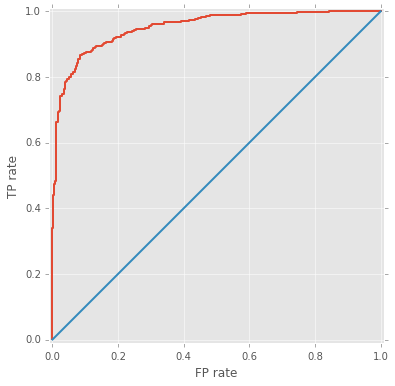

In [51]:
plot_roc(test_y,test_pred_pr)

### Mutation effect

In [134]:
pr_diff,class_diff=[],[]
for j in xrange(10):
    mut_one_hot_train_x=np.array(one_hot_train_x)

    for i in range(len(mut_one_hot_test_x)):
        #introduce random mut in +-10
        pos=np.random.randint(0,1000)-500
        #shift
        roll=np.random.randint(1,4)

        mut_one_hot_train_x[i][0][500+pos]=np.roll(mut_one_hot_train_x[i][0][500+pos],roll)

    mut_train_pred_pr=model.predict(mut_one_hot_train_x,verbose=1).ravel()
    mut_train_pred=np.int8(mut_train_pred_pr>0.5)
    pr_diff.append(mut_train_pred_pr-train_pred_pr)
    class_diff.append(mut_train_pred-train_pred)
pr_diff=np.array(pr_diff).flatten()
class_diff=np.array(class_diff).flatten()

36788/36788 [==============================] - 8s     


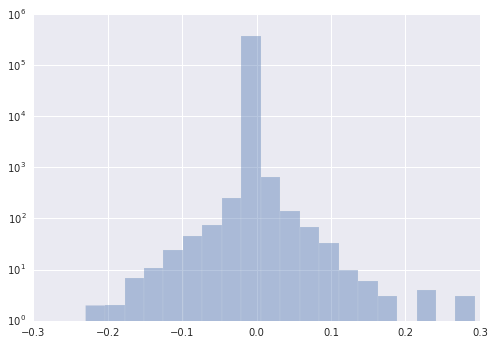

In [135]:
import seaborn as sns
sns.distplot(pr_diff,rug=False,kde=False,bins=20)
plt.yscale('log')

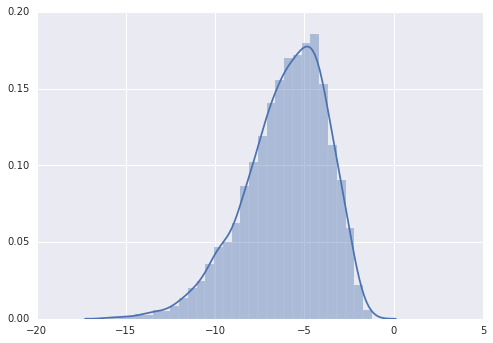

In [144]:
diff=mut_train_pred_pr-train_pred_pr
sns.distplot(np.log(np.abs(pr_diff[pr_diff!=0])),rug=False,bins=30)

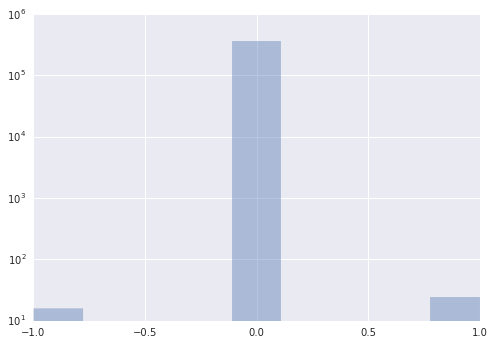

In [143]:
sns.distplot(class_diff,rug=False,kde=False,bins=9)
plt.yscale('log')